In [ ]:
#AUTHOR: TUSHAR MITTAL

In [1]:
import os
import re
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple
from dataclasses import dataclass, field
from collections import Counter

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    set_seed
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from datasets import Dataset, DatasetDict
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    accuracy_score, classification_report, confusion_matrix
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [5]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.6/221.6 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.3/377.3 kB 33.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.12.0
    Uninstalling fsspec-2025.12.0:
      Successfully uninstalled fsspec-2025.12.0


In [6]:
pip install indic-nlp-library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 132.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 11.7 MB/s eta 0:00:00


In [2]:
# Reproducibility
SEED = 42
set_seed(SEED)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


Device: cuda
GPU: Tesla T4
Memory: 15.8 GB


In [3]:
@dataclass
class Config:
    """Experiment configuration"""

    # Model checkpoints
    indicbert_checkpoint: str = "ai4bharat/IndicBERTv2-MLM-Sam-TLM"
    muril_checkpoint: str = "google/muril-base-cased"

    # Training hyperparameters
    max_length: int = 128
    batch_size: int = 16
    learning_rate: float = 2e-4
    num_epochs: int = 5
    weight_decay: float = 0.01
    warmup_ratio: float = 0.1

    # LoRA configuration
    lora_r: int = 16
    lora_alpha: int = 32
    lora_dropout: float = 0.1

    # Label mapping (HASOC format)
    label2id: Dict[str, int] = field(default_factory=lambda: {"NOT": 0, "HOF": 1})
    id2label: Dict[int, str] = field(default_factory=lambda: {0: "NOT", 1: "HOF"})

    # Output directory
    output_dir: str = "./results"

    def __post_init__(self):
        os.makedirs(self.output_dir, exist_ok=True)

config = Config()

In [4]:
class IndicPreprocessor:
    """
    Text preprocessor for Hindi and Marathi using indic-nlp-library.

    Critical for proper tokenization of Devanagari script.
    """

    def __init__(self, lang: str = "hi"):
        self.lang = lang
        try:
            from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
            factory = IndicNormalizerFactory()
            self.normalizer = factory.get_normalizer(lang)
            print(f"✓ Indic normalizer loaded for: {lang}")
        except ImportError:
            self.normalizer = None
            print(f"⚠ indic-nlp-library not found, using basic preprocessing")

    def clean(self, text: str) -> str:
        """Clean and normalize text"""
        if not isinstance(text, str):
            return ""

        # Unicode normalization
        if self.normalizer:
            text = self.normalizer.normalize(text)

        # Remove URLs and mentions
        text = re.sub(r'http\S+|www\.\S+', '', text)
        text = re.sub(r'@\w+', '', text)

        # Clean whitespace
        text = ' '.join(text.split())

        return text.strip()

    def clean_batch(self, texts: List[str]) -> List[str]:
        return [self.clean(t) for t in texts]

# Initialize
hindi_prep = IndicPreprocessor("hi")
marathi_prep = IndicPreprocessor("mr")

✓ Indic normalizer loaded for: hi
✓ Indic normalizer loaded for: mr


In [5]:
def sample_few_shot(dataset: Dataset, k: int, seed: int = 42):
    """
    Sample k examples per class for few-shot learning.

    Args:
        dataset: Full dataset to sample from
        k: Number of examples per class (k-shot)
        seed: Random seed for reproducibility

    Returns:
        (few_shot_dataset, remaining_dataset)
    """
    df = dataset.to_pandas()

    # Sample k examples per class
    few_shot_samples = []
    remaining_samples = []

    for label in df['label'].unique():
        label_data = df[df['label'] == label]

        # Shuffle and sample
        label_data = label_data.sample(frac=1, random_state=seed).reset_index(drop=True)

        few_shot_samples.append(label_data[:k])
        remaining_samples.append(label_data[k:])

    few_shot_df = pd.concat(few_shot_samples, ignore_index=True)
    remaining_df = pd.concat(remaining_samples, ignore_index=True)

    # Shuffle again
    few_shot_df = few_shot_df.sample(frac=1, random_state=seed).reset_index(drop=True)
    remaining_df = remaining_df.sample(frac=1, random_state=seed).reset_index(drop=True)

    return (
        Dataset.from_pandas(few_shot_df[["text", "label"]]),
        Dataset.from_pandas(remaining_df[["text", "label"]])
    )


def combine_datasets(train_data, few_shot_data):
    """
    Combine Hindi training data with few-shot Marathi examples.

    Args:
        train_data: Hindi training DatasetDict
        few_shot_data: Few-shot Marathi Dataset

    Returns:
        Combined DatasetDict
    """
    # Get Hindi train data as DataFrame
    hindi_df = train_data["train"].to_pandas()
    marathi_df = few_shot_data.to_pandas()

    # Combine and shuffle
    combined_df = pd.concat([hindi_df, marathi_df], ignore_index=True)
    combined_df = combined_df.sample(frac=1, random_state=SEED).reset_index(drop=True)

    return DatasetDict({
        "train": Dataset.from_pandas(combined_df[["text", "label"]]),
        "test": train_data["test"]  # Keep original Hindi test set
    })


print("✓ Few-shot learning utilities loaded")


✓ Few-shot learning utilities loaded


In [6]:
def load_combined_hindi(train_files, test_file, text_col="text", label_col="task_1"):
    """
    Combine multiple Hindi training files for more training data.
    Handles files with different label column names (task1 vs task_1).

    Args:
        train_files: List of paths to training files (can be .xlsx, .csv, or .tsv)
        test_file: Path to test file
        text_col: Name of text column (default: "text")
        label_col: Default label column name (tries both "task1" and "task_1")

    Returns:
        Combined DatasetDict with merged training data
    """
    prep = hindi_prep
    all_train_dfs = []

    # Load and combine all training files
    for train_path in train_files:
        print(f"📂 Loading: {train_path}")
        train_df = data_manager._read_file(train_path)

        # Handle different label column names
        actual_label_col = None
        if "task1" in train_df.columns:
            actual_label_col = "task1"
        elif "task_1" in train_df.columns:
            actual_label_col = "task_1"
        else:
            actual_label_col = label_col

        train_df = train_df.rename(columns={text_col: "text", actual_label_col: "label"})

        # Convert labels if needed
        if train_df["label"].dtype == object:
            train_df["label"] = train_df["label"].map(config.label2id)

        train_df = train_df.dropna(subset=["text", "label"])
        print(f"  ✓ {len(train_df)} samples loaded")
        all_train_dfs.append(train_df)

    # Combine all training data
    combined_train = pd.concat(all_train_dfs, ignore_index=True)

    # Remove duplicates (some datasets may overlap)
    original_size = len(combined_train)
    combined_train = combined_train.drop_duplicates(subset=['text'], keep='first')
    removed = original_size - len(combined_train)
    if removed > 0:
        print(f"\n⚠️  Removed {removed} duplicate samples")

    # Clean text
    combined_train["text"] = prep.clean_batch(combined_train["text"].tolist())
    combined_train = combined_train[combined_train["text"].str.len() > 0]
    combined_train["label"] = combined_train["label"].astype(int)

    # Load test data
    print(f"\n📂 Loading test: {test_file}")
    test_df = data_manager._read_file(test_file)

    # Handle test file label column
    actual_test_label_col = None
    if "task1" in test_df.columns:
        actual_test_label_col = "task1"
    elif "task_1" in test_df.columns:
        actual_test_label_col = "task_1"
    else:
        actual_test_label_col = label_col

    test_df = test_df.rename(columns={text_col: "text", actual_test_label_col: "label"})
    if test_df["label"].dtype == object:
        test_df["label"] = test_df["label"].map(config.label2id)
    test_df = test_df.dropna(subset=["text", "label"])
    test_df["text"] = prep.clean_batch(test_df["text"].tolist())
    test_df = test_df[test_df["text"].str.len() > 0]
    test_df["label"] = test_df["label"].astype(int)

    print(f"\n✅ Combined Hindi Data:")
    print(f"  Train: {len(combined_train)} samples")
    print(f"  Test: {len(test_df)} samples")
    print(f"  Labels: {dict(Counter(combined_train['label']))}")

    return DatasetDict({
        "train": Dataset.from_pandas(combined_train[["text", "label"]].reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df[["text", "label"]].reset_index(drop=True))
    })


print("✓ Combined dataset loader added (handles TSV, CSV, and Excel files)")


✓ Combined dataset loader added (handles TSV, CSV, and Excel files)


In [7]:
class DataManager:
    """Load and prepare HASOC datasets"""

    def __init__(self, config: Config):
        self.config = config

    def _read_file(self, file_path: str):
        """Read CSV, TSV, or Excel file automatically"""
        # Convert GitHub URLs to raw URLs
        if 'github.com' in file_path and '/blob/' in file_path:
            file_path = file_path.replace('github.com', 'raw.githubusercontent.com').replace('/blob/', '/')

        if file_path.endswith('.xlsx') or file_path.endswith('.xls'):
            return pd.read_excel(file_path)
        elif file_path.endswith('.tsv'):
            return pd.read_csv(file_path, sep='\t')  # TSV uses tab separator
        else:
            return pd.read_csv(file_path)  # CSV with comma separator

    def load_csv(self, train_path: str, test_path: str = None,
                 text_col: str = "text", label_col: str = "task_1",
                 lang: str = "hindi") -> DatasetDict:
        """
        Load data from CSV or Excel files.

        Expected format:
            text,task_1
            "यह अच्छा है",NOT
            "इनको मारो",HOF
        """
        prep = hindi_prep if lang == "hindi" else marathi_prep

        # Load train
        print(f"Loading training data from: {train_path}")
        train_df = self._read_file(train_path)
        train_df = train_df.rename(columns={text_col: "text", label_col: "label"})

        # Convert labels
        if train_df["label"].dtype == object:
            train_df["label"] = train_df["label"].map(self.config.label2id)

        train_df = train_df.dropna(subset=["text", "label"])
        train_df["text"] = prep.clean_batch(train_df["text"].tolist())
        train_df = train_df[train_df["text"].str.len() > 0]
        train_df["label"] = train_df["label"].astype(int)

        # Load or split test
        if test_path:
            print(f"Loading test data from: {test_path}")
            test_df = self._read_file(test_path)
            test_df = test_df.rename(columns={text_col: "text", label_col: "label"})
            if test_df["label"].dtype == object:
                test_df["label"] = test_df["label"].map(self.config.label2id)
            test_df = test_df.dropna(subset=["text", "label"])
            test_df["text"] = prep.clean_batch(test_df["text"].tolist())
            test_df = test_df[test_df["text"].str.len() > 0]
            test_df["label"] = test_df["label"].astype(int)
        else:
            train_df, test_df = train_test_split(
                train_df, test_size=0.2, random_state=SEED, stratify=train_df["label"]
            )

        print(f"\n{lang.upper()} Data:")
        print(f"  Train: {len(train_df)} samples")
        print(f"  Test: {len(test_df)} samples")
        print(f"  Labels: {dict(Counter(train_df['label']))}")

        return DatasetDict({
            "train": Dataset.from_pandas(train_df[["text", "label"]].reset_index(drop=True)),
            "test": Dataset.from_pandas(test_df[["text", "label"]].reset_index(drop=True))
        })

    def load_sample(self, lang: str = "hindi") -> DatasetDict:
        """Load sample data for testing"""

        if lang == "hindi":
            data = {
                "text": [
                    "आज मौसम बहुत अच्छा है", "मुझे यह फिल्म पसंद आई",
                    "भारत एक सुंदर देश है", "क्रिकेट मैच रोमांचक था",
                    "दिवाली की शुभकामनाएं", "खाना बहुत स्वादिष्ट था",
                    "बच्चे स्कूल जा रहे हैं", "नया साल मुबारक",
                    "यह किताब अच्छी है", "आज खुशी का दिन है",
                    "इन लोगों को देश से निकालो", "ये सब बेवकूफ हैं",
                    "इनको मार डालो", "ये देशद्रोही हैं",
                    "इन गंदे लोगों से दूर रहो", "ये कमीने हैं",
                    "इनकी औकात नहीं है", "सबको खत्म कर दो",
                    "ये नीच लोग हैं", "इनको सबक सिखाओ",
                ],
                "label": [0]*10 + [1]*10
            }
        else:  # marathi
            data = {
                "text": [
                    "आज हवामान खूप छान आहे", "मला हा चित्रपट आवडला",
                    "भारत एक सुंदर देश आहे", "क्रिकेट सामना रोमांचक होता",
                    "दिवाळीच्या शुभेच्छा", "जेवण खूप स्वादिष्ट होते",
                    "मुले शाळेत जात आहेत", "नवीन वर्षाच्या शुभेच्छा",
                    "पुणे सुंदर शहर आहे", "महाराष्ट्र माझा अभिमान",
                    "या लोकांना हाकलून द्या", "हे सगळे मूर्ख आहेत",
                    "त्यांना मारून टाका", "हे देशद्रोही आहेत",
                    "या गंद्या लोकांपासून दूर राहा", "हे कमीने आहेत",
                    "यांची लायकी नाही", "सगळ्यांना संपवा",
                    "ही घाण माणसं आहेत", "यांना जगण्याचा अधिकार नाही",
                ],
                "label": [0]*10 + [1]*10
            }

        prep = hindi_prep if lang == "hindi" else marathi_prep
        data["text"] = prep.clean_batch(data["text"])

        df = pd.DataFrame(data)
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df["label"])

        return DatasetDict({
            "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
            "test": Dataset.from_pandas(test_df.reset_index(drop=True))
        })

data_manager = DataManager(config)

In [8]:
class ModelFactory:
    """Create models with different training strategies"""

    def __init__(self, config: Config):
        self.config = config

    def create(self, model_name: str, num_labels: int = 2, training_mode: str = "lora") -> Tuple:
        """
        Create model with different training strategies.

        Args:
            model_name: "indicbert" or "muril"
            num_labels: Number of classification labels (default: 2)
            training_mode:
                - "normal": No fine-tuning (frozen, 0 trainable params)
                - "lora": LoRA fine-tuning (~0.95% params)
                - "sft": Supervised Full Fine-tuning (100% params)

        Returns:
            (model, tokenizer)
        """
        checkpoints = {
            "indicbert": self.config.indicbert_checkpoint,
            "muril": self.config.muril_checkpoint
        }
        checkpoint = checkpoints.get(model_name.lower(), model_name)

        # Method name for display
        method_names = {
            "normal": "No Fine-tuning (Frozen)",
            "lora": "LoRA (Parameter-Efficient)",
            "sft": "SFT (Full Fine-tuning)"
        }
        method = method_names.get(training_mode, training_mode)

        print(f"\n{'='*50}")
        print(f"Loading: {model_name.upper()} ({method})")
        print(f"{'='*50}")

        tokenizer = AutoTokenizer.from_pretrained(checkpoint)

        # Load base model
        base_model = AutoModelForSequenceClassification.from_pretrained(
            checkpoint,
            num_labels=num_labels
        )

        if training_mode == "lora":
            # Apply LoRA for parameter-efficient fine-tuning
            lora_config = LoraConfig(
                task_type=TaskType.SEQ_CLS,
                r=self.config.lora_r,
                lora_alpha=self.config.lora_alpha,
                lora_dropout=self.config.lora_dropout,
                target_modules=["query", "key", "value", "dense"]
            )
            model = get_peft_model(base_model, lora_config)

        elif training_mode == "sft":
            # Full fine-tuning - train all parameters
            model = base_model

        elif training_mode == "normal":
            # No fine-tuning - freeze all parameters except classifier
            model = base_model
            # Freeze all base model parameters
            for param in model.base_model.parameters():
                param.requires_grad = False
            # Only classifier head is trainable

        else:
            raise ValueError(f"Unknown training_mode: {training_mode}. Use 'normal', 'lora', or 'sft'")

        # Calculate trainable parameters
        trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
        total = sum(p.numel() for p in model.parameters())

        print(f"Total parameters: {total:,}")
        print(f"Trainable parameters: {trainable:,} ({100*trainable/total:.2f}%)")

        if training_mode == "lora":
            print(f"Efficiency: {total/trainable:.1f}x fewer trainable params than SFT")
        elif training_mode == "normal":
            print(f"Efficiency: {total/trainable:.0f}x fewer trainable params than SFT (classifier only)")

        return model, tokenizer

model_factory = ModelFactory(config)

In [9]:
def compute_metrics(eval_pred) -> Dict[str, float]:
    """Compute evaluation metrics (HASOC uses Macro-F1 as primary)"""
    preds = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids

    return {
        "macro_f1": f1_score(labels, preds, average="macro"),
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
    }

def evaluate_model(model, tokenizer, dataset, config: Config) -> Dict:
    """Detailed evaluation with confusion matrix"""
    model.eval()
    dev = next(model.parameters()).device

    def tok_fn(ex):
        return tokenizer(ex["text"], padding="max_length", truncation=True, max_length=config.max_length)

    tok_data = dataset.map(tok_fn, batched=True, remove_columns=["text"])
    tok_data.set_format("torch")

    loader = DataLoader(tok_data, batch_size=32)

    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            out = model(
                input_ids=batch["input_ids"].to(dev),
                attention_mask=batch["attention_mask"].to(dev)
            )
            preds = torch.argmax(out.logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch["label"].numpy())

    return {
        "macro_f1": f1_score(all_labels, all_preds, average="macro"),
        "accuracy": accuracy_score(all_labels, all_preds),
        "confusion_matrix": confusion_matrix(all_labels, all_preds),
        "report": classification_report(all_labels, all_preds, target_names=["NOT", "HOF"], output_dict=True)
    }

In [10]:
def train_model(model, tokenizer, dataset: DatasetDict,
                config: Config, name: str) -> Trainer:
    """Train a model"""

    def tok_fn(ex):
        return tokenizer(ex["text"], padding="max_length", truncation=True, max_length=config.max_length)

    tok_data = dataset.map(tok_fn, batched=True, remove_columns=["text"])

    args = TrainingArguments(
        output_dir=f"{config.output_dir}/{name}",
        learning_rate=config.learning_rate,
        per_device_train_batch_size=config.batch_size,
        per_device_eval_batch_size=config.batch_size * 2,
        num_train_epochs=config.num_epochs,
        weight_decay=config.weight_decay,
        warmup_ratio=config.warmup_ratio,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        greater_is_better=True,
        fp16=torch.cuda.is_available(),
        logging_steps=50,
        report_to="none",
        seed=SEED,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tok_data["train"],
        eval_dataset=tok_data["test"],
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics,
    )

    print(f"\n🚀 Training {name}...")
    trainer.train()

    return trainer

In [11]:
def plot_learning_curves(results_dict: Dict, title: str = "Learning Curves: Hindi→Marathi Transfer"):
    """
    Plot learning curves showing how performance improves with more examples.

    Args:
        results_dict: Dictionary with shot sizes as keys and results as values
                     Format: {0: {model: {f1, acc}}, 5: {...}, ...}
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Organize data by model
    models = {}
    shot_sizes = sorted(results_dict.keys())

    for shot in shot_sizes:
        for model_name, metrics in results_dict[shot].items():
            if model_name not in models:
                models[model_name] = {'shots': [], 'f1': [], 'acc': []}
            models[model_name]['shots'].append(shot)
            models[model_name]['f1'].append(metrics['macro_f1'])
            models[model_name]['acc'].append(metrics['accuracy'])

    # Plot F1 scores
    colors = ['steelblue', 'darkorange']
    markers = ['o', 's']

    for (model_name, data), color, marker in zip(models.items(), colors, markers):
        ax1.plot(data['shots'], data['f1'], marker=marker, linewidth=2,
                markersize=8, label=model_name, color=color)

    ax1.set_xlabel('Number of Marathi Examples (per class)', fontsize=12)
    ax1.set_ylabel('Macro-F1 Score', fontsize=12)
    ax1.set_title('F1 Score vs Training Examples', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xscale('symlog')  # Better visualization with 0

    # Plot Accuracy
    for (model_name, data), color, marker in zip(models.items(), colors, markers):
        ax2.plot(data['shots'], data['acc'], marker=marker, linewidth=2,
                markersize=8, label=model_name, color=color)

    ax2.set_xlabel('Number of Marathi Examples (per class)', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Accuracy vs Training Examples', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xscale('symlog')

    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    # Print improvement summary
    print("\n" + "="*60)
    print("LEARNING EFFICIENCY ANALYSIS")
    print("="*60)

    for model_name, data in models.items():
        zero_shot_f1 = data['f1'][0]
        few_shot_f1 = data['f1'][1] if len(data['f1']) > 1 else zero_shot_f1
        full_f1 = data['f1'][-1]

        improvement_5shot = few_shot_f1 - zero_shot_f1
        improvement_total = full_f1 - zero_shot_f1

        print(f"\n{model_name}:")
        print(f"  Zero-shot F1: {zero_shot_f1:.4f}")
        if len(data['f1']) > 1:
            print(f"  {data['shots'][1]}-shot F1: {few_shot_f1:.4f} (+{improvement_5shot:.4f})")
        print(f"  Full training F1: {full_f1:.4f} (+{improvement_total:.4f})")
        print(f"  Gain from just {data['shots'][1] if len(data['shots']) > 1 else 0} examples/class: {improvement_5shot/improvement_total*100:.1f}% of total gain")


print("✓ Learning curve visualization loaded")


✓ Learning curve visualization loaded


In [12]:
def plot_comparison(results: Dict, title: str = "Model Comparison"):
    """Plot comparison bar chart"""
    models = list(results.keys())
    metrics = ["macro_f1", "accuracy"]

    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(models))
    width = 0.35

    f1_scores = [results[m]["macro_f1"] for m in models]
    acc_scores = [results[m]["accuracy"] for m in models]

    bars1 = ax.bar(x - width/2, f1_scores, width, label="Macro-F1", color="steelblue")
    bars2 = ax.bar(x + width/2, acc_scores, width, label="Accuracy", color="darkorange")

    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.set_ylim(0, 1)

    for bars in [bars1, bars2]:
        for bar in bars:
            h = bar.get_height()
            ax.annotate(f'{h:.3f}', xy=(bar.get_x() + bar.get_width()/2, h),
                       ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results: Dict):
    """Plot confusion matrices side by side"""
    n = len(results)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 4))
    if n == 1:
        axes = [axes]

    for ax, (name, res) in zip(axes, results.items()):
        sns.heatmap(res["confusion_matrix"], annot=True, fmt="d", cmap="Blues",
                   xticklabels=["NOT", "HOF"], yticklabels=["NOT", "HOF"], ax=ax)
        ax.set_title(f"{name}\nF1={res['macro_f1']:.3f}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    plt.tight_layout()
    plt.show()

In [13]:
def compare_training_methods(hindi_data, marathi_data, shot_sizes=[0, 10]):
    """
    Compare three training strategies: Normal (no fine-tuning) vs LoRA vs SFT.

    This experiment compares:
    - Normal: No fine-tuning, frozen model (~1K params - classifier only)
    - LoRA: Parameter-efficient fine-tuning (~2.6M params, 0.95%)
    - SFT: Supervised Full Fine-tuning (110M params, 100%)

    Args:
        hindi_data: Hindi DatasetDict
        marathi_data: Marathi DatasetDict
        shot_sizes: Which shot sizes to compare (default: [0, 10])

    Returns:
        comparison_results: Dict with results for all three methods
    """

    print("\n" + "="*70)
    print("TRAINING METHODS COMPARISON: Normal vs LoRA vs SFT")
    print("="*70)
    print(f"\nComparing three training strategies:")
    print(f"  1. Normal: No fine-tuning (frozen, ~1K params)")
    print(f"  2. LoRA: Parameter-efficient (~2.6M params)")
    print(f"  3. SFT: Full fine-tuning (~110M params)")
    print(f"\nShot sizes: {shot_sizes}")
    print(f"Models: IndicBERT v2, MuRIL")

    all_results = {}
    training_modes = ["normal", "lora", "sft"]
    mode_names = {
        "normal": "Normal",
        "lora": "LoRA",
        "sft": "SFT"
    }

    for mode in training_modes:
        method_name = mode_names[mode]
        print(f"\n{'='*70}")
        print(f"METHOD: {method_name.upper()}")
        print(f"{'='*70}")

        method_results = {}

        for k in shot_sizes:
            print(f"\n--- {k}-shot with {method_name} ---")

            # Prepare data
            if k > 0:
                few_shot_marathi, _ = sample_few_shot(marathi_data["train"], k=k, seed=SEED)
                train_data = combine_datasets(hindi_data, few_shot_marathi)
            else:
                train_data = hindi_data

            k_results = {}

            # Test IndicBERT
            print(f"\n[1/2] IndicBERT ({method_name}, k={k})...")
            indicbert, indicbert_tok = model_factory.create("indicbert", training_mode=mode)
            indicbert.to(device)

            if mode == "normal":
                # For normal mode, skip training and just evaluate
                indicbert_results = evaluate_model(indicbert, indicbert_tok, marathi_data["test"], config)
            else:
                # Train the model
                indicbert_trainer = train_model(
                    indicbert, indicbert_tok, train_data, config,
                    f"indicbert_{mode}_k{k}"
                )
                indicbert_results = evaluate_model(indicbert, indicbert_tok, marathi_data["test"], config)
                del indicbert_trainer

            k_results["IndicBERT"] = {
                "macro_f1": indicbert_results["macro_f1"],
                "accuracy": indicbert_results["accuracy"]
            }
            print(f"  → F1: {indicbert_results['macro_f1']:.4f}")

            # Clear memory
            del indicbert, indicbert_tok
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

            # Test MuRIL
            print(f"\n[2/2] MuRIL ({method_name}, k={k})...")
            muril, muril_tok = model_factory.create("muril", training_mode=mode)
            muril.to(device)

            if mode == "normal":
                # For normal mode, skip training and just evaluate
                muril_results = evaluate_model(muril, muril_tok, marathi_data["test"], config)
            else:
                # Train the model
                muril_trainer = train_model(
                    muril, muril_tok, train_data, config,
                    f"muril_{mode}_k{k}"
                )
                muril_results = evaluate_model(muril, muril_tok, marathi_data["test"], config)
                del muril_trainer

            k_results["MuRIL"] = {
                "macro_f1": muril_results["macro_f1"],
                "accuracy": muril_results["accuracy"]
            }
            print(f"  → F1: {muril_results['macro_f1']:.4f}")

            # Clear memory
            del muril, muril_tok
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

            method_results[k] = k_results

        all_results[method_name] = method_results

    # Print comparison
    print("\n" + "="*70)
    print("COMPARISON RESULTS")
    print("="*70)

    comparison_data = []
    for k in shot_sizes:
        for model in ["IndicBERT", "MuRIL"]:
            normal_f1 = all_results["Normal"][k][model]["macro_f1"]
            lora_f1 = all_results["LoRA"][k][model]["macro_f1"]
            sft_f1 = all_results["SFT"][k][model]["macro_f1"]

            comparison_data.append({
                "K-Shot": k,
                "Model": model,
                "Normal F1": f"{normal_f1:.4f}",
                "LoRA F1": f"{lora_f1:.4f}",
                "SFT F1": f"{sft_f1:.4f}",
                "LoRA Gain": f"{lora_f1 - normal_f1:+.4f}",
                "SFT Gain": f"{sft_f1 - lora_f1:+.4f}"
            })

    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + comparison_df.to_string(index=False))

    # Analysis
    print("\n" + "="*70)
    print("KEY INSIGHTS")
    print("="*70)

    avg_normal_f1 = np.mean([all_results["Normal"][k][m]["macro_f1"]
                              for k in shot_sizes for m in ["IndicBERT", "MuRIL"]])
    avg_lora_f1 = np.mean([all_results["LoRA"][k][m]["macro_f1"]
                            for k in shot_sizes for m in ["IndicBERT", "MuRIL"]])
    avg_sft_f1 = np.mean([all_results["SFT"][k][m]["macro_f1"]
                           for k in shot_sizes for m in ["IndicBERT", "MuRIL"]])

    print(f"\nAverage Performance:")
    print(f"  Normal (no training):  {avg_normal_f1:.4f}  (baseline)")
    print(f"  LoRA (0.95% params):   {avg_lora_f1:.4f}  ({avg_lora_f1 - avg_normal_f1:+.4f} vs Normal)")
    print(f"  SFT (100% params):     {avg_sft_f1:.4f}  ({avg_sft_f1 - avg_lora_f1:+.4f} vs LoRA)")

    lora_gain = avg_lora_f1 - avg_normal_f1
    sft_gain = avg_sft_f1 - avg_lora_f1

    print(f"\nEfficiency Analysis:")
    if lora_gain > 0.05:
        print(f"  ✓ LoRA provides significant improvement (+{lora_gain:.4f}) with minimal params")
    else:
        print(f"  ⚠ LoRA shows limited benefit (+{lora_gain:.4f}) over frozen model")

    if abs(sft_gain) < 0.01:
        print(f"  ✓ LoRA matches SFT performance ({sft_gain:+.4f}) - BEST CHOICE!")
        print(f"    → Same quality, 100x fewer parameters")
    elif sft_gain > 0.01:
        print(f"  → SFT outperforms LoRA by {sft_gain:+.4f}")
        print(f"    → Trade-off: +{sft_gain:.4f} F1 for 100x more parameters")
    else:
        print(f"  ✓ LoRA outperforms SFT by {-sft_gain:.4f} - parameter efficiency wins!")

    return all_results, comparison_df


print("✓ Training methods comparison function loaded (Normal vs LoRA vs SFT)")


✓ Training methods comparison function loaded (Normal vs LoRA vs SFT)


In [14]:
def plot_training_methods_comparison(results_dict):
    """
    Visualize Normal vs LoRA vs SFT comparison.

    Args:
        results_dict: Output from compare_training_methods()
    """
    # Extract data
    shot_sizes = sorted(results_dict["Normal"].keys())

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

    # Plot 1: IndicBERT - All three methods
    indicbert_normal = [results_dict["Normal"][k]["IndicBERT"]["macro_f1"] for k in shot_sizes]
    indicbert_lora = [results_dict["LoRA"][k]["IndicBERT"]["macro_f1"] for k in shot_sizes]
    indicbert_sft = [results_dict["SFT"][k]["IndicBERT"]["macro_f1"] for k in shot_sizes]

    ax1.plot(shot_sizes, indicbert_normal, '^-', linewidth=2, markersize=10,
             label="Normal (no training)", color="gray")
    ax1.plot(shot_sizes, indicbert_lora, 'o-', linewidth=2, markersize=10,
             label="LoRA (0.95% params)", color="steelblue")
    ax1.plot(shot_sizes, indicbert_sft, 's-', linewidth=2, markersize=10,
             label="SFT (100% params)", color="darkblue")
    ax1.set_xlabel("Marathi Examples per Class", fontsize=12)
    ax1.set_ylabel("Macro F1 Score", fontsize=12)
    ax1.set_title("IndicBERT: Training Method Comparison", fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_xscale('symlog')

    # Plot 2: MuRIL - All three methods
    muril_normal = [results_dict["Normal"][k]["MuRIL"]["macro_f1"] for k in shot_sizes]
    muril_lora = [results_dict["LoRA"][k]["MuRIL"]["macro_f1"] for k in shot_sizes]
    muril_sft = [results_dict["SFT"][k]["MuRIL"]["macro_f1"] for k in shot_sizes]

    ax2.plot(shot_sizes, muril_normal, '^-', linewidth=2, markersize=10,
             label="Normal (no training)", color="gray")
    ax2.plot(shot_sizes, muril_lora, 'o-', linewidth=2, markersize=10,
             label="LoRA (0.95% params)", color="darkorange")
    ax2.plot(shot_sizes, muril_sft, 's-', linewidth=2, markersize=10,
             label="SFT (100% params)", color="darkred")
    ax2.set_xlabel("Marathi Examples per Class", fontsize=12)
    ax2.set_ylabel("Macro F1 Score", fontsize=12)
    ax2.set_title("MuRIL: Training Method Comparison", fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xscale('symlog')

    # Plot 3: Gain from LoRA and SFT
    indicbert_lora_gain = np.array(indicbert_lora) - np.array(indicbert_normal)
    indicbert_sft_gain = np.array(indicbert_sft) - np.array(indicbert_normal)
    muril_lora_gain = np.array(muril_lora) - np.array(muril_normal)
    muril_sft_gain = np.array(muril_sft) - np.array(muril_normal)

    x = np.arange(len(shot_sizes))
    width = 0.2

    ax3.bar(x - 1.5*width, indicbert_lora_gain, width, label="IndicBERT LoRA", color="steelblue")
    ax3.bar(x - 0.5*width, indicbert_sft_gain, width, label="IndicBERT SFT", color="darkblue")
    ax3.bar(x + 0.5*width, muril_lora_gain, width, label="MuRIL LoRA", color="darkorange")
    ax3.bar(x + 1.5*width, muril_sft_gain, width, label="MuRIL SFT", color="darkred")
    ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax3.set_xlabel("Shot Size", fontsize=12)
    ax3.set_ylabel("F1 Improvement vs Normal", fontsize=12)
    ax3.set_title("Training Benefit vs No Fine-tuning", fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels([f"{k}-shot" for k in shot_sizes])
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3, axis='y')

    # Plot 4: Average Performance Summary
    methods = ['Normal\n(frozen)', 'LoRA\n(0.95%)', 'SFT\n(100%)']
    indicbert_avg = [np.mean(indicbert_normal), np.mean(indicbert_lora), np.mean(indicbert_sft)]
    muril_avg = [np.mean(muril_normal), np.mean(muril_lora), np.mean(muril_sft)]

    x = np.arange(len(methods))
    width = 0.35

    bars1 = ax4.bar(x - width/2, indicbert_avg, width, label="IndicBERT", color="steelblue")
    bars2 = ax4.bar(x + width/2, muril_avg, width, label="MuRIL", color="darkorange")

    ax4.set_ylabel("Average Macro F1", fontsize=12)
    ax4.set_title("Average Performance Across All Methods", fontsize=14, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(methods, fontsize=11)
    ax4.legend(fontsize=11)
    ax4.set_ylim(0, 1)
    ax4.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()


print("✓ Training methods visualization loaded (Normal vs LoRA vs SFT)")


✓ Training methods visualization loaded (Normal vs LoRA vs SFT)


In [15]:
def run_experiment(hindi_train: str = None, hindi_test: str = None,
                   marathi_train: str = None, marathi_test: str = None):
    """
    Run the complete experiment.

    Args:
        hindi_train: Path to Hindi training CSV
        hindi_test: Path to Hindi test CSV
        marathi_train: Path to Marathi training CSV
        marathi_test: Path to Marathi test CSV
    """

    print("="*60)
    print("IndicBERT v2 vs MuRIL: Hindi Hate Speech Detection")
    print("="*60)

    results = {}

    # --- Load Data ---
    print("\n[1/5] Loading Data...")

    if hindi_train:
        hindi_data = data_manager.load_csv(hindi_train, hindi_test, lang="hindi")
    else:
        print("Using sample Hindi data")
        hindi_data = data_manager.load_sample("hindi")

    if marathi_train or marathi_test:
        marathi_data = data_manager.load_csv(
            marathi_train or marathi_test, marathi_test, lang="marathi"
        )
    else:
        print("Using sample Marathi data")
        marathi_data = data_manager.load_sample("marathi")

    # --- Train IndicBERT ---
    print("\n[2/5] Training IndicBERT v2 on Hindi...")

    indicbert, indicbert_tok = model_factory.create("indicbert")
    indicbert.to(device)

    indicbert_trainer = train_model(indicbert, indicbert_tok, hindi_data, config, "indicbert")
    indicbert_hindi = indicbert_trainer.evaluate()

    results["IndicBERT (Hindi)"] = {
        "macro_f1": indicbert_hindi["eval_macro_f1"],
        "accuracy": indicbert_hindi["eval_accuracy"]
    }

    # --- Train MuRIL ---
    print("\n[3/5] Training MuRIL on Hindi...")

    muril, muril_tok = model_factory.create("muril")
    muril.to(device)

    muril_trainer = train_model(muril, muril_tok, hindi_data, config, "muril")
    muril_hindi = muril_trainer.evaluate()

    results["MuRIL (Hindi)"] = {
        "macro_f1": muril_hindi["eval_macro_f1"],
        "accuracy": muril_hindi["eval_accuracy"]
    }

    # --- Cross-lingual: Hindi → Marathi ---
    print("\n[4/5] Zero-Shot Evaluation: Hindi → Marathi...")

    indicbert_marathi = evaluate_model(indicbert, indicbert_tok, marathi_data["test"], config)
    results["IndicBERT (→Marathi)"] = {
        "macro_f1": indicbert_marathi["macro_f1"],
        "accuracy": indicbert_marathi["accuracy"],
        "confusion_matrix": indicbert_marathi["confusion_matrix"]
    }

    muril_marathi = evaluate_model(muril, muril_tok, marathi_data["test"], config)
    results["MuRIL (→Marathi)"] = {
        "macro_f1": muril_marathi["macro_f1"],
        "accuracy": muril_marathi["accuracy"],
        "confusion_matrix": muril_marathi["confusion_matrix"]
    }

    # --- Results ---
    print("\n[5/5] Results...")

    print("\n" + "="*60)
    print("RESULTS SUMMARY")
    print("="*60)

    summary = pd.DataFrame([
        {"Model": k, "Macro-F1": v["macro_f1"], "Accuracy": v["accuracy"]}
        for k, v in results.items()
    ])
    print(summary.to_string(index=False))

    # Analysis
    print("\n" + "-"*60)
    print("ANALYSIS")
    print("-"*60)

    hindi_winner = "IndicBERT" if results["IndicBERT (Hindi)"]["macro_f1"] > results["MuRIL (Hindi)"]["macro_f1"] else "MuRIL"
    marathi_winner = "IndicBERT" if results["IndicBERT (→Marathi)"]["macro_f1"] > results["MuRIL (→Marathi)"]["macro_f1"] else "MuRIL"

    print(f"\nHindi (in-language): {hindi_winner} performs better")
    print(f"Marathi (zero-shot): {marathi_winner} performs better")

    indicbert_drop = results["IndicBERT (Hindi)"]["macro_f1"] - results["IndicBERT (→Marathi)"]["macro_f1"]
    muril_drop = results["MuRIL (Hindi)"]["macro_f1"] - results["MuRIL (→Marathi)"]["macro_f1"]

    print(f"\nCross-lingual performance drop:")
    print(f"  IndicBERT: {indicbert_drop:+.4f}")
    print(f"  MuRIL: {muril_drop:+.4f}")

    if muril_drop < indicbert_drop:
        print(f"\n→ MuRIL shows better cross-lingual transfer (smaller drop)")
        print(f"  This supports the hypothesis that TLM pretraining helps")
    else:
        print(f"\n→ IndicBERT shows better cross-lingual transfer")

    # Visualizations
    print("\n" + "-"*60)
    print("VISUALIZATIONS")
    print("-"*60)

    plot_comparison(results, "IndicBERT v2 vs MuRIL Comparison")

    cross_lingual = {
        "IndicBERT (→Marathi)": results["IndicBERT (→Marathi)"],
        "MuRIL (→Marathi)": results["MuRIL (→Marathi)"]
    }
    plot_confusion_matrices(cross_lingual)

    return results, summary


    ╔════════════════════════════════════════════════════════════╗
    ║  Hindi Hate Speech Detection: IndicBERT v2 vs MuRIL        ║
    ╠════════════════════════════════════════════════════════════╣
    ║                                                            ║
    ║  Comparing two Indic-focused encoders:                     ║
    ║                                                            ║
    ║  • IndicBERT v2: Indic-only pretraining (24 languages)     ║
    ║    - Trained on IndicCorp v2 (20.9B tokens)                ║
    ║    - Indic-optimized vocabulary (250K tokens)              ║
    ║                                                            ║
    ║  • MuRIL: Translation Language Modeling (17 languages)     ║
    ║    - TLM + transliteration-aware pretraining               ║
    ║    - Better cross-lingual alignment                        ║
    ║                                                            ║
    ║  Experiments:                                          

tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.75M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/IndicBERTv2-MLM-Sam-TLM and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Total parameters: 280,723,204
Trainable parameters: 2,680,322 (0.95%)
Efficiency: 104.7x fewer trainable params than SFT


Map:   0%|          | 0/13326 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 3}.



🚀 Training indicbert...


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Precision,Recall
1,0.399300,0.472830,0.723496,0.790347,0.759881,0.707278
2,0.357500,0.449803,0.732259,0.799397,0.776775,0.713715
3,0.335000,0.456509,0.752991,0.794872,0.754547,0.751520
4,0.265000,0.522625,0.739305,0.788839,0.748204,0.732577
5,0.231800,0.574963,0.740745,0.790347,0.750251,0.733650



[3/5] Training MuRIL on Hindi...

Loading: MURIL (LoRA (Parameter-Efficient))


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 240,238,084
Trainable parameters: 2,680,322 (1.12%)
Efficiency: 89.6x fewer trainable params than SFT


model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

Map:   0%|          | 0/13326 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]


🚀 Training muril...


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Precision,Recall
1,0.425800,0.495516,0.665321,0.775264,0.776883,0.649664
2,0.387400,0.469544,0.716989,0.791855,0.770416,0.698095
3,0.345100,0.449089,0.757926,0.803922,0.767472,0.750632
4,0.273800,0.490599,0.749458,0.799397,0.762982,0.740087
5,0.255200,0.532579,0.753226,0.802413,0.766937,0.743698



[5/5] Results...

RESULTS SUMMARY
            Model  Macro-F1  Accuracy
IndicBERT (Hindi)  0.752991  0.794872
    MuRIL (Hindi)  0.757926  0.803922

------------------------------------------------------------
ANALYSIS
------------------------------------------------------------

Hindi (in-language): MuRIL performs better

------------------------------------------------------------
VISUALIZATIONS
------------------------------------------------------------


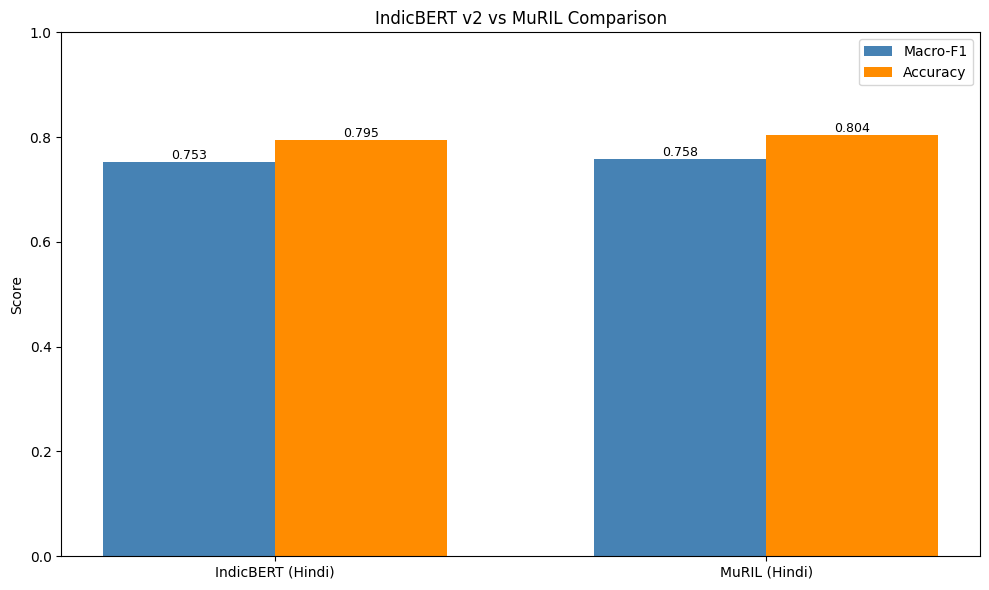


✅ Experiment complete!


In [17]:
if __name__ == "__main__":

    print("""
    ╔════════════════════════════════════════════════════════════╗
    ║  Hindi Hate Speech Detection: IndicBERT v2 vs MuRIL        ║
    ╠════════════════════════════════════════════════════════════╣
    ║                                                            ║
    ║  Comparing two Indic-focused encoders:                     ║
    ║                                                            ║
    ║  • IndicBERT v2: Indic-only pretraining (24 languages)     ║
    ║    - Trained on IndicCorp v2 (20.9B tokens)                ║
    ║    - Indic-optimized vocabulary (250K tokens)              ║
    ║                                                            ║
    ║  • MuRIL: Translation Language Modeling (17 languages)     ║
    ║    - TLM + transliteration-aware pretraining               ║
    ║    - Better cross-lingual alignment                        ║
    ║                                                            ║
    ║  Experiments:                                              ║
    ║  1. Hindi hate speech detection (in-language)              ║
    ║                                                            ║
    ╚════════════════════════════════════════════════════════════╝
    """)

    # =========================================================================
    # OPTION 1: Run with sample data (for testing)
    # =========================================================================

    # results, summary = run_experiment()

    # =========================================================================
    # OPTION 2: Run with your uploaded HASOC data files
    # =========================================================================

    # Running with the uploaded local files
    # Note: Hindi uses 'task1' column, Marathi uses 'task_1' column

    print("\n📁 Using uploaded HASOC dataset files...")

    # Load Hindi data with correct column name
    # hindi_data = data_manager.load_csv(
    #     "/content/hasoc_2020_hi_train.xlsx",
    #     "/content/hindi_test_1509.csv",
    #     text_col="text",
    #     label_col="task1",  # Hindi uses 'task1' (no underscore)
    #     lang="hindi"
    # )
    hindi_data = load_combined_hindi(
        train_files=[
        "hasoc_2020_hi_train.xlsx",      # Your current file (2,963 samples)
        "hindi_2019_1.tsv",        # HASOC-2021 train
        "hindi_2019_2.tsv",
        "hindi_2021.csv"          # HASOC-2021 dev (use as extra training)
        ],
        test_file="hindi_test_1509.csv",      # Keep same test set
        text_col="text",
        label_col="task1"  # or "task_1" depending on file
        )

    # Load Marathi data with correct column name
    marathi_data = data_manager.load_csv(
        "mr_Hasoc2021_train.xlsx",
        None,  # No separate test file, will split from train
        text_col="text",
        label_col="task_1",  # Marathi uses 'task_1' (with underscore)
        lang="marathi"
    )

    # Now run the experiment with the loaded data
    results = {}

    # --- Train IndicBERT ---
    print("\n[2/5] Training IndicBERT v2 on Hindi...")
    indicbert, indicbert_tok = model_factory.create("indicbert")
    indicbert.to(device)

    indicbert_trainer = train_model(indicbert, indicbert_tok, hindi_data, config, "indicbert")
    indicbert_hindi = indicbert_trainer.evaluate()

    results["IndicBERT (Hindi)"] = {
        "macro_f1": indicbert_hindi["eval_macro_f1"],
        "accuracy": indicbert_hindi["eval_accuracy"]
    }

    # --- Train MuRIL ---
    print("\n[3/5] Training MuRIL on Hindi...")
    muril, muril_tok = model_factory.create("muril")
    muril.to(device)

    muril_trainer = train_model(muril, muril_tok, hindi_data, config, "muril")
    muril_hindi = muril_trainer.evaluate()

    results["MuRIL (Hindi)"] = {
        "macro_f1": muril_hindi["eval_macro_f1"],
        "accuracy": muril_hindi["eval_accuracy"]
    }

    # # --- Cross-lingual: Hindi → Marathi ---
    # print("\n[4/5] Zero-Shot Evaluation: Hindi → Marathi...")

    # indicbert_marathi = evaluate_model(indicbert, indicbert_tok, marathi_data["test"], config)
    # results["IndicBERT (→Marathi)"] = {
    #     "macro_f1": indicbert_marathi["macro_f1"],
    #     "accuracy": indicbert_marathi["accuracy"],
    #     "confusion_matrix": indicbert_marathi["confusion_matrix"]
    # }

    # muril_marathi = evaluate_model(muril, muril_tok, marathi_data["test"], config)
    # results["MuRIL (→Marathi)"] = {
    #     "macro_f1": muril_marathi["macro_f1"],
    #     "accuracy": muril_marathi["accuracy"],
    #     "confusion_matrix": muril_marathi["confusion_matrix"]
    # }

    # --- Results ---
    print("\n[5/5] Results...")

    print("\n" + "="*60)
    print("RESULTS SUMMARY")
    print("="*60)

    summary = pd.DataFrame([
        {"Model": k, "Macro-F1": v["macro_f1"], "Accuracy": v["accuracy"]}
        for k, v in results.items()
    ])
    print(summary.to_string(index=False))

    # Analysis
    print("\n" + "-"*60)
    print("ANALYSIS")
    print("-"*60)

    hindi_winner = "IndicBERT" if results["IndicBERT (Hindi)"]["macro_f1"] > results["MuRIL (Hindi)"]["macro_f1"] else "MuRIL"
    # marathi_winner = "IndicBERT" if results["IndicBERT (→Marathi)"]["macro_f1"] > results["MuRIL (→Marathi)"]["macro_f1"] else "MuRIL"

    print(f"\nHindi (in-language): {hindi_winner} performs better")
    # print(f"Marathi (zero-shot): {marathi_winner} performs better")

    # indicbert_drop = results["IndicBERT (Hindi)"]["macro_f1"] - results["IndicBERT (→Marathi)"]["macro_f1"]
    # muril_drop = results["MuRIL (Hindi)"]["macro_f1"] - results["MuRIL (→Marathi)"]["macro_f1"]

    # print(f"\nCross-lingual performance drop:")
    # print(f"  IndicBERT: {indicbert_drop:+.4f}")
    # print(f"  MuRIL: {muril_drop:+.4f}")

    # if muril_drop < indicbert_drop:
    #     print(f"\n→ MuRIL shows better cross-lingual transfer (smaller drop)")
    #     print(f"  This supports the hypothesis that TLM pretraining helps")
    # else:
    #     print(f"\n→ IndicBERT shows better cross-lingual transfer")

    # Visualizations
    print("\n" + "-"*60)
    print("VISUALIZATIONS")
    print("-"*60)

    plot_comparison(results, "IndicBERT v2 vs MuRIL Comparison")

    # cross_lingual = {
    #     "IndicBERT (→Marathi)": results["IndicBERT (→Marathi)"],
    #     "MuRIL (→Marathi)": results["MuRIL (→Marathi)"]
    # }
    # plot_confusion_matrices(cross_lingual)

    print("\n✅ Experiment complete!")



In [ ]:
pip install 'accelerate>=0.26.0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


zsh:1: unmatched '
Note: you may need to restart the kernel to use updated packages.


In [18]:
def run_few_shot_experiment(hindi_data, marathi_data, shot_sizes=[0, 5, 10, 50]):
    """
    Run few-shot learning experiment with different numbers of Marathi examples.

    Args:
        hindi_data: Hindi training DatasetDict
        marathi_data: Marathi DatasetDict
        shot_sizes: List of k values for k-shot learning (0 = zero-shot)

    Returns:
        results_dict: {shot_size: {model_name: {f1, acc, ...}}}
    """

    print("\n" + "="*70)
    print("FEW-SHOT CROSS-LINGUAL TRANSFER EXPERIMENT")
    print("="*70)
    print(f"\nTesting with: {shot_sizes} examples per class")
    print(f"Models: IndicBERT v2 vs MuRIL")
    print(f"Task: Hindi → Marathi hate speech detection")

    all_results = {}

    for k in shot_sizes:
        print("\n" + "="*70)
        if k == 0:
            print(f"ZERO-SHOT LEARNING (No Marathi examples)")
        else:
            print(f"{k}-SHOT LEARNING ({k} Marathi examples per class = {k*2} total)")
        print("="*70)

        # Sample few-shot data if k > 0
        if k > 0:
            few_shot_marathi, remaining_marathi = sample_few_shot(
                marathi_data["train"], k=k, seed=SEED
            )
            print(f"✓ Sampled {k} examples per class from Marathi")
            print(f"  Total training examples: {len(few_shot_marathi)}")
        else:
            few_shot_marathi = None
            remaining_marathi = marathi_data["train"]

        k_results = {}

        # --- IndicBERT ---
        print(f"\n[1/2] Training IndicBERT v2 (k={k})...")

        indicbert, indicbert_tok = model_factory.create("indicbert")
        indicbert.to(device)

        # Combine Hindi + k-shot Marathi (if k > 0)
        if k > 0:
            train_data = combine_datasets(hindi_data, few_shot_marathi)
            print(f"  Combined Hindi ({len(hindi_data['train'])}) + Marathi ({k*2}) = {len(train_data['train'])} examples")
        else:
            train_data = hindi_data

        indicbert_trainer = train_model(
            indicbert, indicbert_tok, train_data, config, f"indicbert_k{k}"
        )

        # Evaluate on Marathi test set
        indicbert_results = evaluate_model(
            indicbert, indicbert_tok, marathi_data["test"], config
        )

        k_results["IndicBERT"] = {
            "macro_f1": indicbert_results["macro_f1"],
            "accuracy": indicbert_results["accuracy"],
            "confusion_matrix": indicbert_results["confusion_matrix"]
        }

        print(f"  IndicBERT F1: {indicbert_results['macro_f1']:.4f}, Acc: {indicbert_results['accuracy']:.4f}")

        # Clear memory
        del indicbert, indicbert_tok, indicbert_trainer
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

        # --- MuRIL ---
        print(f"\n[2/2] Training MuRIL (k={k})...")

        muril, muril_tok = model_factory.create("muril")
        muril.to(device)

        # Use same training data
        muril_trainer = train_model(
            muril, muril_tok, train_data, config, f"muril_k{k}"
        )

        # Evaluate on Marathi test set
        muril_results = evaluate_model(
            muril, muril_tok, marathi_data["test"], config
        )

        k_results["MuRIL"] = {
            "macro_f1": muril_results["macro_f1"],
            "accuracy": muril_results["accuracy"],
            "confusion_matrix": muril_results["confusion_matrix"]
        }

        print(f"  MuRIL F1: {muril_results['macro_f1']:.4f}, Acc: {muril_results['accuracy']:.4f}")

        # Clear memory
        del muril, muril_tok, muril_trainer
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

        all_results[k] = k_results

        # Summary for this k
        print(f"\n  Summary (k={k}):")
        print(f"    IndicBERT: F1={k_results['IndicBERT']['macro_f1']:.4f}")
        print(f"    MuRIL:     F1={k_results['MuRIL']['macro_f1']:.4f}")
        winner = "MuRIL" if k_results['MuRIL']['macro_f1'] > k_results['IndicBERT']['macro_f1'] else "IndicBERT"
        print(f"    Winner: {winner}")

    # Final summary
    print("\n" + "="*70)
    print("FINAL RESULTS: All Shot Sizes")
    print("="*70)

    summary_data = []
    for k in shot_sizes:
        for model in ["IndicBERT", "MuRIL"]:
            summary_data.append({
                "K-Shot": k,
                "Model": model,
                "Macro-F1": all_results[k][model]["macro_f1"],
                "Accuracy": all_results[k][model]["accuracy"]
            })

    summary_df = pd.DataFrame(summary_data)
    print("\n" + summary_df.to_string(index=False))

    return all_results, summary_df


print("✓ Few-shot experiment function loaded")


✓ Few-shot experiment function loaded



    ╔════════════════════════════════════════════════════════════════════╗
    ║  Hindi→Marathi Hate Speech: Few-Shot Cross-Lingual Transfer      ║
    ╠════════════════════════════════════════════════════════════════════╣
    ║                                                                    ║
    ║  Comparing IndicBERT v2 vs MuRIL:                                  ║
    ║                                                                    ║
    ║  • IndicBERT v2: Indic-only pretraining (24 languages)            ║
    ║    - Trained on IndicCorp v2 (20.9B tokens)                       ║
    ║    - Indic-optimized vocabulary (250K tokens)                     ║
    ║                                                                    ║
    ║  • MuRIL: Translation Language Modeling (17 languages)            ║
    ║    - TLM + transliteration-aware pretraining                      ║
    ║    - Better cross-lingual alignment                                ║
    ║                          

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/IndicBERTv2-MLM-Sam-TLM and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 280,723,204
Trainable parameters: 2,680,322 (0.95%)
Efficiency: 104.7x fewer trainable params than SFT


Map:   0%|          | 0/13326 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 3}.



🚀 Training indicbert_k0...


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Precision,Recall
1,0.402700,0.457393,0.724314,0.799397,0.786648,0.703460
2,0.362700,0.433274,0.758444,0.812971,0.787853,0.742418
3,0.326200,0.452771,0.770537,0.811463,0.775495,0.766252
4,0.276700,0.490550,0.748344,0.800905,0.766693,0.736765
5,0.222700,0.572607,0.746928,0.793363,0.753416,0.741656


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  IndicBERT F1: 0.7935, Acc: 0.8187

[2/2] Training MuRIL (k=0)...

Loading: MURIL (LoRA (Parameter-Efficient))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 240,238,084
Trainable parameters: 2,680,322 (1.12%)
Efficiency: 89.6x fewer trainable params than SFT


Map:   0%|          | 0/13326 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]


🚀 Training muril_k0...


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Precision,Recall
1,0.425800,0.495516,0.665321,0.775264,0.776883,0.649664
2,0.387400,0.469544,0.716989,0.791855,0.770416,0.698095
3,0.345100,0.449089,0.757926,0.803922,0.767472,0.750632
4,0.273800,0.490599,0.749458,0.799397,0.762982,0.740087
5,0.255200,0.532579,0.753226,0.802413,0.766937,0.743698


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  MuRIL F1: 0.7840, Acc: 0.8080

  Summary (k=0):
    IndicBERT: F1=0.7935
    MuRIL:     F1=0.7840
    Winner: IndicBERT

5-SHOT LEARNING (5 Marathi examples per class = 10 total)
✓ Sampled 5 examples per class from Marathi
  Total training examples: 10

[1/2] Training IndicBERT v2 (k=5)...

Loading: INDICBERT (LoRA (Parameter-Efficient))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/IndicBERTv2-MLM-Sam-TLM and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 280,723,204
Trainable parameters: 2,680,322 (0.95%)
Efficiency: 104.7x fewer trainable params than SFT
  Combined Hindi (13326) + Marathi (10) = 13336 examples


Map:   0%|          | 0/13336 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 3}.



🚀 Training indicbert_k5...


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Precision,Recall
1,0.399500,0.447717,0.701244,0.788839,0.779760,0.681298
2,0.313600,0.444034,0.712949,0.800905,0.812191,0.689881
3,0.285200,0.463506,0.739944,0.800905,0.773266,0.723579
4,0.263700,0.497858,0.756603,0.799397,0.760370,0.753273
5,0.235300,0.543774,0.759947,0.814480,0.790487,0.743491


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  IndicBERT F1: 0.7904, Acc: 0.8213

[2/2] Training MuRIL (k=5)...

Loading: MURIL (LoRA (Parameter-Efficient))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 240,238,084
Trainable parameters: 2,680,322 (1.12%)
Efficiency: 89.6x fewer trainable params than SFT


Map:   0%|          | 0/13336 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]


🚀 Training muril_k5...


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Precision,Recall
1,0.418400,0.464485,0.695507,0.782805,0.765203,0.677006
2,0.322200,0.451772,0.700583,0.779789,0.750699,0.683651
3,0.311300,0.471498,0.716723,0.790347,0.766085,0.698487
4,0.303900,0.520832,0.745304,0.793363,0.753857,0.738726
5,0.289100,0.593978,0.726416,0.782805,0.741950,0.716564


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  MuRIL F1: 0.8174, Acc: 0.8373

  Summary (k=5):
    IndicBERT: F1=0.7904
    MuRIL:     F1=0.8174
    Winner: MuRIL

10-SHOT LEARNING (10 Marathi examples per class = 20 total)
✓ Sampled 10 examples per class from Marathi
  Total training examples: 20

[1/2] Training IndicBERT v2 (k=10)...

Loading: INDICBERT (LoRA (Parameter-Efficient))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/IndicBERTv2-MLM-Sam-TLM and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 280,723,204
Trainable parameters: 2,680,322 (0.95%)
Efficiency: 104.7x fewer trainable params than SFT
  Combined Hindi (13326) + Marathi (20) = 13346 examples


Map:   0%|          | 0/13346 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 3}.



🚀 Training indicbert_k10...


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Precision,Recall
1,0.401700,0.443064,0.701298,0.790347,0.785666,0.680906
2,0.312900,0.449661,0.784552,0.823529,0.790846,0.779231
3,0.322300,0.450666,0.726400,0.793363,0.765362,0.709424
4,0.289900,0.509985,0.755089,0.799397,0.760756,0.750343
5,0.258000,0.559125,0.745994,0.799397,0.764933,0.734227


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  IndicBERT F1: 0.8238, Acc: 0.8373

[2/2] Training MuRIL (k=10)...

Loading: MURIL (LoRA (Parameter-Efficient))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 240,238,084
Trainable parameters: 2,680,322 (1.12%)
Efficiency: 89.6x fewer trainable params than SFT


Map:   0%|          | 0/13346 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]


🚀 Training muril_k10...


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Precision,Recall
1,0.412100,0.434028,0.736004,0.797888,0.768852,0.719968
2,0.352900,0.441966,0.757805,0.805430,0.770426,0.748775
3,0.326200,0.487330,0.716155,0.787330,0.758069,0.699271
4,0.295200,0.525446,0.743617,0.785822,0.743617,0.743617
5,0.249800,0.589383,0.730712,0.790347,0.754765,0.717533


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  MuRIL F1: 0.8057, Acc: 0.8240

  Summary (k=10):
    IndicBERT: F1=0.8238
    MuRIL:     F1=0.8057
    Winner: IndicBERT

50-SHOT LEARNING (50 Marathi examples per class = 100 total)
✓ Sampled 50 examples per class from Marathi
  Total training examples: 100

[1/2] Training IndicBERT v2 (k=50)...

Loading: INDICBERT (LoRA (Parameter-Efficient))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/IndicBERTv2-MLM-Sam-TLM and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 280,723,204
Trainable parameters: 2,680,322 (0.95%)
Efficiency: 104.7x fewer trainable params than SFT
  Combined Hindi (13326) + Marathi (100) = 13426 examples


Map:   0%|          | 0/13426 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 3}.



🚀 Training indicbert_k50...


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Precision,Recall
1,0.396200,0.436712,0.739539,0.787330,0.745842,0.734434
2,0.350000,0.485283,0.667967,0.785822,0.830486,0.651315
3,0.292600,0.425823,0.757648,0.806938,0.773656,0.746917
4,0.286400,0.507985,0.746371,0.808446,0.788240,0.727479
5,0.237300,0.520499,0.766804,0.812971,0.780506,0.757070


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  IndicBERT F1: 0.8007, Acc: 0.8160

[2/2] Training MuRIL (k=50)...

Loading: MURIL (LoRA (Parameter-Efficient))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 240,238,084
Trainable parameters: 2,680,322 (1.12%)
Efficiency: 89.6x fewer trainable params than SFT


Map:   0%|          | 0/13426 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]


🚀 Training muril_k50...


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Precision,Recall
1,0.422900,0.447739,0.695565,0.785822,0.776114,0.676222
2,0.381800,0.485392,0.692395,0.791855,0.808587,0.671723
3,0.291300,0.457615,0.764507,0.802413,0.763386,0.765675
4,0.308900,0.497271,0.736528,0.796380,0.764639,0.721825
5,0.270600,0.523318,0.752584,0.800905,0.764339,0.744091


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  MuRIL F1: 0.8218, Acc: 0.8293

  Summary (k=50):
    IndicBERT: F1=0.8007
    MuRIL:     F1=0.8218
    Winner: MuRIL

FINAL RESULTS: All Shot Sizes

 K-Shot     Model  Macro-F1  Accuracy
      0 IndicBERT  0.793462  0.818667
      0     MuRIL  0.784000  0.808000
      5 IndicBERT  0.790431  0.821333
      5     MuRIL  0.817364  0.837333
     10 IndicBERT  0.823780  0.837333
     10     MuRIL  0.805730  0.824000
     50 IndicBERT  0.800669  0.816000
     50     MuRIL  0.821821  0.829333

VISUALIZATIONS


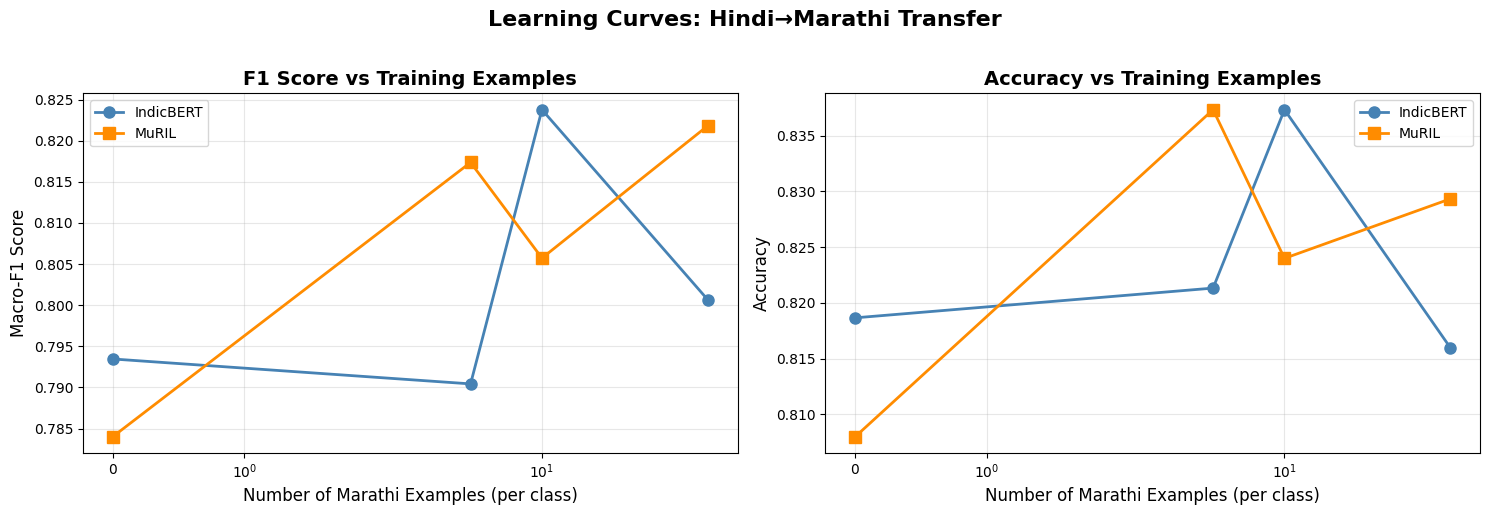


LEARNING EFFICIENCY ANALYSIS

IndicBERT:
  Zero-shot F1: 0.7935
  5-shot F1: 0.7904 (+-0.0030)
  Full training F1: 0.8007 (+0.0072)
  Gain from just 5 examples/class: -42.1% of total gain

MuRIL:
  Zero-shot F1: 0.7840
  5-shot F1: 0.8174 (+0.0334)
  Full training F1: 0.8218 (+0.0378)
  Gain from just 5 examples/class: 88.2% of total gain

Confusion Matrices:


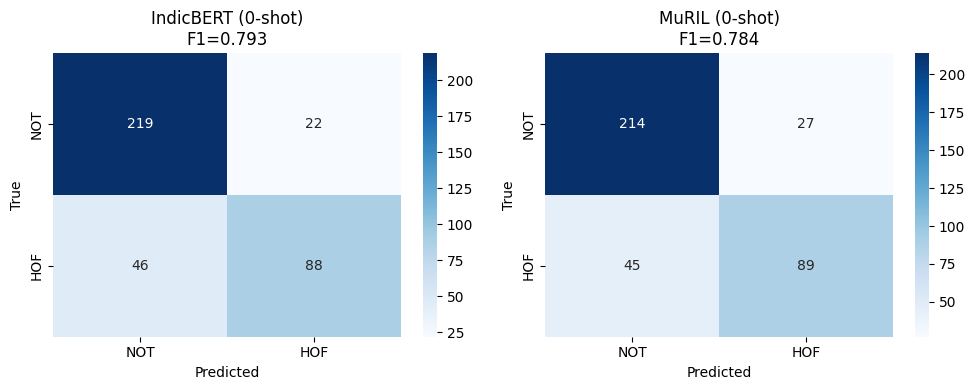

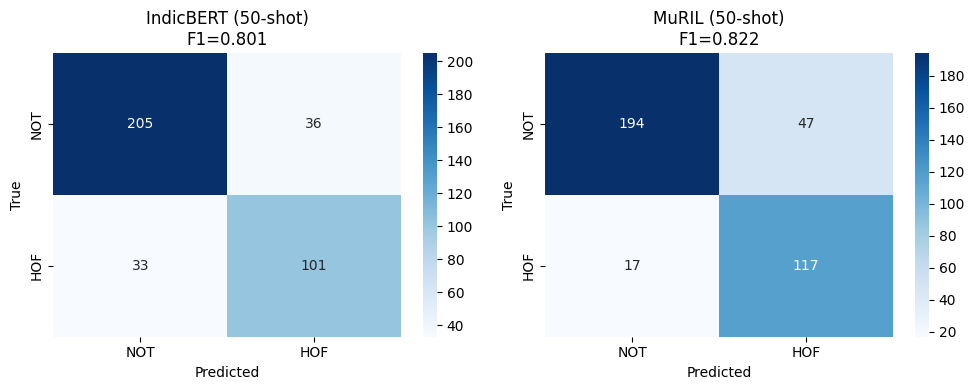


KEY FINDINGS

1. Zero-Shot Transfer:
   IndicBERT: 0.7935
   MuRIL: 0.7840
   → IndicBERT performs better without any Marathi examples

2. Few-Shot Learning Efficiency (5 examples/class):
   IndicBERT improvement: +-0.0030
   MuRIL improvement: +0.0334
   → MuRIL learns faster from few examples
   → This supports MuRIL's cross-lingual advantage

3. Overall Best Performance (50 examples/class):
   IndicBERT: 0.8007
   MuRIL: 0.8218
   → MuRIL achieves highest performance

✅ Experiment complete!

Results saved in: ./results


In [19]:
if __name__ == "__main__":

    print("""
    ╔════════════════════════════════════════════════════════════════════╗
    ║  Hindi→Marathi Hate Speech: Few-Shot Cross-Lingual Transfer      ║
    ╠════════════════════════════════════════════════════════════════════╣
    ║                                                                    ║
    ║  Comparing IndicBERT v2 vs MuRIL:                                  ║
    ║                                                                    ║
    ║  • IndicBERT v2: Indic-only pretraining (24 languages)            ║
    ║    - Trained on IndicCorp v2 (20.9B tokens)                       ║
    ║    - Indic-optimized vocabulary (250K tokens)                     ║
    ║                                                                    ║
    ║  • MuRIL: Translation Language Modeling (17 languages)            ║
    ║    - TLM + transliteration-aware pretraining                      ║
    ║    - Better cross-lingual alignment                                ║
    ║                                                                    ║
    ║  Experiments:                                                      ║
    ║  1. Zero-shot transfer (0 Marathi examples)                       ║
    ║  2. Few-shot learning (5, 10, 50 examples per class)              ║
    ║  3. Full training (all available Marathi data)                    ║
    ║                                                                    ║
    ║  Research Question:                                                ║
    ║  Does MuRIL's TLM pretraining enable faster learning from         ║
    ║  few Marathi examples compared to IndicBERT?                      ║
    ╚════════════════════════════════════════════════════════════════════╝
    """)

    # =========================================================================
    # Load Data
    # =========================================================================

    print("\n📁 Loading HASOC dataset files...")

    # Load Hindi data
    hindi_data = load_combined_hindi(
        train_files=[
        "hasoc_2020_hi_train.xlsx",      # Your current file (2,963 samples)
        "hindi_2019_1.tsv",        # HASOC-2021 train
        "hindi_2019_2.tsv",
        "hindi_2021.csv"          # HASOC-2021 dev (use as extra training)
        ],
        test_file="hindi_test_1509.csv",      # Keep same test set
        text_col="text",
        label_col="task1"  # or "task_1" depending on file
        )
    # hindi_data = data_manager.load_csv(
    #     "hasoc_2020_hi_train.xlsx",
    #     "hindi_test_1509.csv",
    #     text_col="text",
    #     label_col="task1",
    #     lang="hindi"
    # )

    # Load Marathi data
    marathi_data = data_manager.load_csv(
        "mr_Hasoc2021_train.xlsx",
        None,
        text_col="text",
        label_col="task_1",
        lang="marathi"
    )

    # =========================================================================
    # Run Few-Shot Experiment
    # =========================================================================

    # Define shot sizes to test
    shot_sizes = [0, 5, 10, 50]  # 0 = zero-shot, others = k-shot

    few_shot_results, summary_df = run_few_shot_experiment(
        hindi_data,
        marathi_data,
        shot_sizes=shot_sizes
    )

    # =========================================================================
    # Visualizations
    # =========================================================================

    print("\n" + "="*70)
    print("VISUALIZATIONS")
    print("="*70)

    # Plot learning curves
    plot_learning_curves(few_shot_results, "Learning Curves: Hindi→Marathi Transfer")

    # Plot confusion matrices for zero-shot and best few-shot
    print("\nConfusion Matrices:")

    zero_shot_cms = {
        "IndicBERT (0-shot)": few_shot_results[0]["IndicBERT"],
        "MuRIL (0-shot)": few_shot_results[0]["MuRIL"]
    }
    plot_confusion_matrices(zero_shot_cms)

    best_k = shot_sizes[-1]
    few_shot_cms = {
        f"IndicBERT ({best_k}-shot)": few_shot_results[best_k]["IndicBERT"],
        f"MuRIL ({best_k}-shot)": few_shot_results[best_k]["MuRIL"]
    }
    plot_confusion_matrices(few_shot_cms)

    # =========================================================================
    # Final Analysis
    # =========================================================================

    print("\n" + "="*70)
    print("KEY FINDINGS")
    print("="*70)

    # Which model has better zero-shot?
    zero_indicbert = few_shot_results[0]["IndicBERT"]["macro_f1"]
    zero_muril = few_shot_results[0]["MuRIL"]["macro_f1"]
    zero_winner = "MuRIL" if zero_muril > zero_indicbert else "IndicBERT"

    print(f"\n1. Zero-Shot Transfer:")
    print(f"   IndicBERT: {zero_indicbert:.4f}")
    print(f"   MuRIL: {zero_muril:.4f}")
    print(f"   → {zero_winner} performs better without any Marathi examples")

    # Learning efficiency (gain from 5-shot)
    if 5 in shot_sizes:
        indicbert_5shot_gain = few_shot_results[5]["IndicBERT"]["macro_f1"] - zero_indicbert
        muril_5shot_gain = few_shot_results[5]["MuRIL"]["macro_f1"] - zero_muril

        print(f"\n2. Few-Shot Learning Efficiency (5 examples/class):")
        print(f"   IndicBERT improvement: +{indicbert_5shot_gain:.4f}")
        print(f"   MuRIL improvement: +{muril_5shot_gain:.4f}")

        if muril_5shot_gain > indicbert_5shot_gain:
            print(f"   → MuRIL learns faster from few examples")
            print(f"   → This supports MuRIL's cross-lingual advantage")
        else:
            print(f"   → IndicBERT learns faster from few examples")

    # Overall best performance
    best_k = shot_sizes[-1]
    final_indicbert = few_shot_results[best_k]["IndicBERT"]["macro_f1"]
    final_muril = few_shot_results[best_k]["MuRIL"]["macro_f1"]
    final_winner = "MuRIL" if final_muril > final_indicbert else "IndicBERT"

    print(f"\n3. Overall Best Performance ({best_k} examples/class):")
    print(f"   IndicBERT: {final_indicbert:.4f}")
    print(f"   MuRIL: {final_muril:.4f}")
    print(f"   → {final_winner} achieves highest performance")

    print("\n✅ Experiment complete!")
    print(f"\nResults saved in: {config.output_dir}")


📂 Loading: hasoc_2020_hi_train.xlsx
  ✓ 2963 samples loaded
📂 Loading: hindi_2019_1.tsv
  ✓ 1318 samples loaded
📂 Loading: hindi_2019_2.tsv
  ✓ 4665 samples loaded
📂 Loading: hindi_2021.csv
  ✓ 4594 samples loaded

⚠️  Removed 212 duplicate samples

📂 Loading test: hindi_test_1509.csv

✅ Combined Hindi Data:
  Train: 13326 samples
  Test: 663 samples
  Labels: {1: 5318, 0: 8008}
Loading training data from: mr_Hasoc2021_train.xlsx

MARATHI Data:
  Train: 1499 samples
  Test: 375 samples
  Labels: {0: 964, 1: 535}

🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬
STARTING TRAINING METHODS COMPARISON
🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬

TRAINING METHODS COMPARISON: Normal vs LoRA vs SFT

Comparing three training strategies:
  1. Normal: No fine-tuning (frozen, ~1K params)
  2. LoRA: Parameter-efficient (~2.6M params)
  3. SFT: Full fine-tuning (~110M params)

Shot sizes: [0, 10]
Models: IndicBERT v2, MuRIL

METHOD: NORMAL

--- 0-shot with Normal ---

[1/2] IndicBERT (Normal, k=0)...

Loading: INDICBER

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/IndicBERTv2-MLM-Sam-TLM and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 278,042,882
Trainable parameters: 1,538 (0.00%)
Efficiency: 180782x fewer trainable params than SFT (classifier only)


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  → F1: 0.3749

[2/2] MuRIL (Normal, k=0)...

Loading: MURIL (No Fine-tuning (Frozen))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 237,557,762
Trainable parameters: 1,538 (0.00%)
Efficiency: 154459x fewer trainable params than SFT (classifier only)


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  → F1: 0.2633

--- 10-shot with Normal ---

[1/2] IndicBERT (Normal, k=10)...

Loading: INDICBERT (No Fine-tuning (Frozen))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/IndicBERTv2-MLM-Sam-TLM and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 278,042,882
Trainable parameters: 1,538 (0.00%)
Efficiency: 180782x fewer trainable params than SFT (classifier only)


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  → F1: 0.3939

[2/2] MuRIL (Normal, k=10)...

Loading: MURIL (No Fine-tuning (Frozen))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 237,557,762
Trainable parameters: 1,538 (0.00%)
Efficiency: 154459x fewer trainable params than SFT (classifier only)


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  → F1: 0.2633

METHOD: LORA

--- 0-shot with LoRA ---

[1/2] IndicBERT (LoRA, k=0)...

Loading: INDICBERT (LoRA (Parameter-Efficient))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/IndicBERTv2-MLM-Sam-TLM and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 280,723,204
Trainable parameters: 2,680,322 (0.95%)
Efficiency: 104.7x fewer trainable params than SFT


Map:   0%|          | 0/13326 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 3}.



🚀 Training indicbert_lora_k0...


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Precision,Recall
1,0.399200,0.487670,0.670373,0.775264,0.769226,0.654060
2,0.370100,0.454622,0.739458,0.799397,0.769759,0.723971
3,0.346700,0.448043,0.760177,0.805430,0.769217,0.753170
4,0.273700,0.501998,0.738714,0.791855,0.753646,0.728862
5,0.234500,0.546773,0.756548,0.800905,0.762756,0.751416


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  → F1: 0.7848

[2/2] MuRIL (LoRA, k=0)...

Loading: MURIL (LoRA (Parameter-Efficient))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 240,238,084
Trainable parameters: 2,680,322 (1.12%)
Efficiency: 89.6x fewer trainable params than SFT


Map:   0%|          | 0/13326 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]


🚀 Training muril_lora_k0...


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Precision,Recall
1,0.425800,0.495516,0.665321,0.775264,0.776883,0.649664
2,0.387400,0.469544,0.716989,0.791855,0.770416,0.698095
3,0.345100,0.449089,0.757926,0.803922,0.767472,0.750632
4,0.273800,0.490599,0.749458,0.799397,0.762982,0.740087
5,0.255200,0.532579,0.753226,0.802413,0.766937,0.743698


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  → F1: 0.7840

--- 10-shot with LoRA ---

[1/2] IndicBERT (LoRA, k=10)...

Loading: INDICBERT (LoRA (Parameter-Efficient))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/IndicBERTv2-MLM-Sam-TLM and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 280,723,204
Trainable parameters: 2,680,322 (0.95%)
Efficiency: 104.7x fewer trainable params than SFT


Map:   0%|          | 0/13346 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 3}.



🚀 Training indicbert_lora_k10...


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Precision,Recall
1,0.401700,0.443064,0.701298,0.790347,0.785666,0.680906
2,0.312900,0.449661,0.784552,0.823529,0.790846,0.779231
3,0.322300,0.450666,0.726400,0.793363,0.765362,0.709424
4,0.289900,0.509985,0.755089,0.799397,0.760756,0.750343
5,0.258000,0.559125,0.745994,0.799397,0.764933,0.734227


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  → F1: 0.8238

[2/2] MuRIL (LoRA, k=10)...

Loading: MURIL (LoRA (Parameter-Efficient))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 240,238,084
Trainable parameters: 2,680,322 (1.12%)
Efficiency: 89.6x fewer trainable params than SFT


Map:   0%|          | 0/13346 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]


🚀 Training muril_lora_k10...


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Precision,Recall
1,0.412100,0.434028,0.736004,0.797888,0.768852,0.719968
2,0.352900,0.441966,0.757805,0.805430,0.770426,0.748775
3,0.326200,0.487330,0.716155,0.787330,0.758069,0.699271
4,0.295200,0.525446,0.743617,0.785822,0.743617,0.743617
5,0.249800,0.589383,0.730712,0.790347,0.754765,0.717533


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  → F1: 0.8057

METHOD: SFT

--- 0-shot with SFT ---

[1/2] IndicBERT (SFT, k=0)...

Loading: INDICBERT (SFT (Full Fine-tuning))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/IndicBERTv2-MLM-Sam-TLM and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 278,042,882
Trainable parameters: 278,042,882 (100.00%)


Map:   0%|          | 0/13326 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 3}.



🚀 Training indicbert_sft_k0...


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Precision,Recall
1,0.690800,0.616761,0.412755,0.702866,0.351433,0.500000
2,0.682700,0.633066,0.412755,0.702866,0.351433,0.500000
3,0.676300,0.634017,0.412755,0.702866,0.351433,0.500000
4,0.677600,0.628797,0.412755,0.702866,0.351433,0.500000
5,0.669600,0.627405,0.412755,0.702866,0.351433,0.500000


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  → F1: 0.3912

[2/2] MuRIL (SFT, k=0)...

Loading: MURIL (SFT (Full Fine-tuning))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 237,557,762
Trainable parameters: 237,557,762 (100.00%)


Map:   0%|          | 0/13326 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]


🚀 Training muril_sft_k0...


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Precision,Recall
1,0.686000,0.630806,0.412755,0.702866,0.351433,0.500000
2,0.678900,0.638379,0.412755,0.702866,0.351433,0.500000
3,0.675100,0.638181,0.412755,0.702866,0.351433,0.500000
4,0.676000,0.632114,0.412755,0.702866,0.351433,0.500000
5,0.668100,0.631559,0.412755,0.702866,0.351433,0.500000


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  → F1: 0.3912

--- 10-shot with SFT ---

[1/2] IndicBERT (SFT, k=10)...

Loading: INDICBERT (SFT (Full Fine-tuning))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/IndicBERTv2-MLM-Sam-TLM and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 278,042,882
Trainable parameters: 278,042,882 (100.00%)


Map:   0%|          | 0/13346 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 3}.



🚀 Training indicbert_sft_k10...


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Precision,Recall
1,0.655500,0.626628,0.412755,0.702866,0.351433,0.500000
2,0.676600,0.646571,0.412755,0.702866,0.351433,0.500000
3,0.674300,0.630912,0.412755,0.702866,0.351433,0.500000
4,0.670300,0.630947,0.412755,0.702866,0.351433,0.500000
5,0.675900,0.625015,0.412755,0.702866,0.351433,0.500000


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  → F1: 0.3912

[2/2] MuRIL (SFT, k=10)...

Loading: MURIL (SFT (Full Fine-tuning))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 237,557,762
Trainable parameters: 237,557,762 (100.00%)


Map:   0%|          | 0/13346 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]


🚀 Training muril_sft_k10...


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Precision,Recall
1,0.653100,0.632511,0.412755,0.702866,0.351433,0.500000
2,0.675700,0.640876,0.412755,0.702866,0.351433,0.500000
3,0.671900,0.629603,0.412755,0.702866,0.351433,0.500000
4,0.669800,0.631254,0.412755,0.702866,0.351433,0.500000
5,0.674200,0.630607,0.412755,0.702866,0.351433,0.500000


Map:   0%|          | 0/375 [00:00<?, ? examples/s]

  → F1: 0.3912

COMPARISON RESULTS

 K-Shot     Model Normal F1 LoRA F1 SFT F1 LoRA Gain SFT Gain
      0 IndicBERT    0.3749  0.7848 0.3912   +0.4099  -0.3936
      0     MuRIL    0.2633  0.7840 0.3912   +0.5207  -0.3928
     10 IndicBERT    0.3939  0.8238 0.3912   +0.4298  -0.4325
     10     MuRIL    0.2633  0.8057 0.3912   +0.5425  -0.4145

KEY INSIGHTS

Average Performance:
  Normal (no training):  0.3238  (baseline)
  LoRA (0.95% params):   0.7996  (+0.4757 vs Normal)
  SFT (100% params):     0.3912  (-0.4083 vs LoRA)

Efficiency Analysis:
  ✓ LoRA provides significant improvement (+0.4757) with minimal params
  ✓ LoRA outperforms SFT by 0.4083 - parameter efficiency wins!


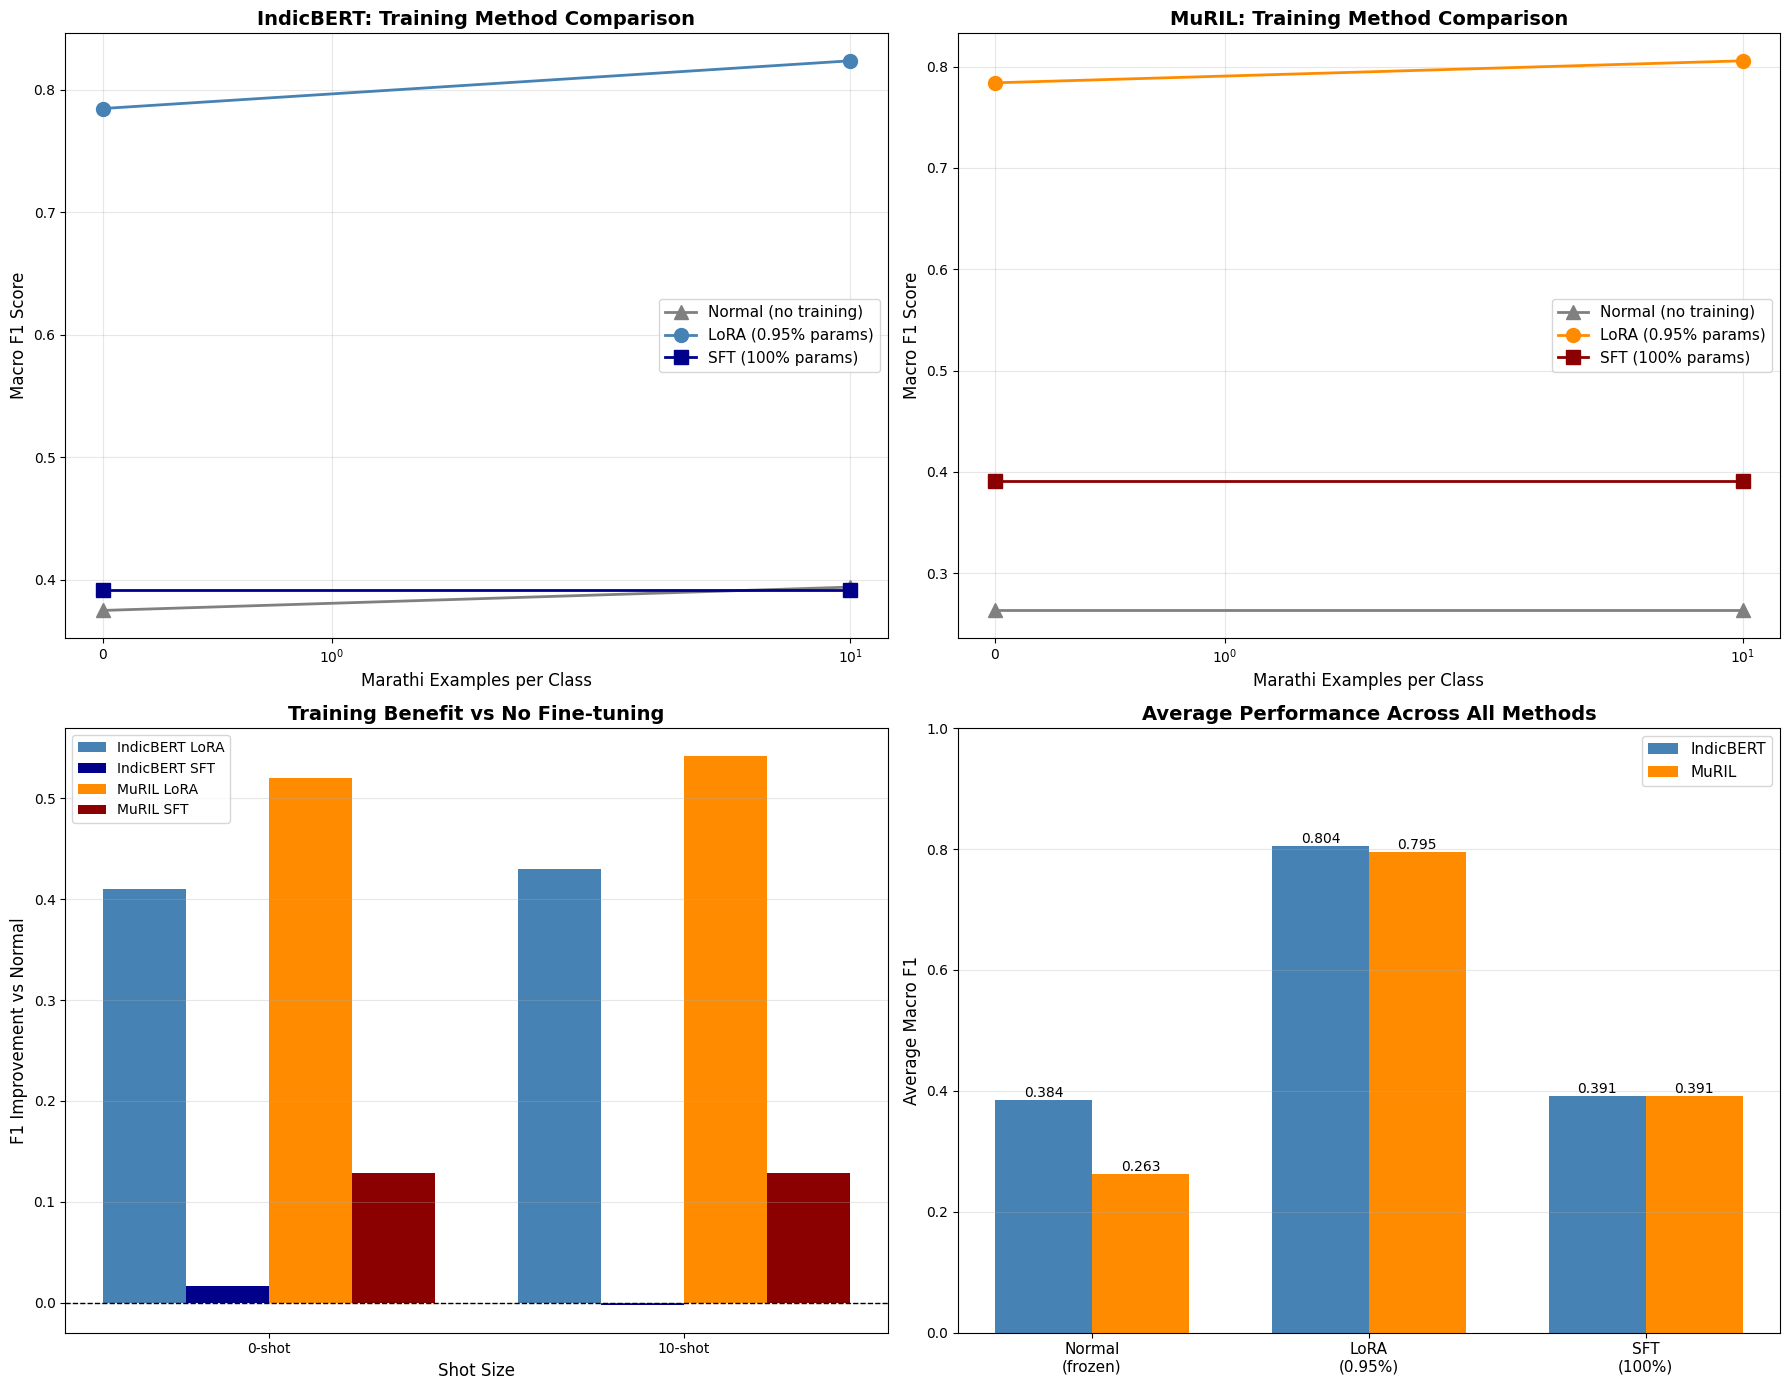


FINAL VERDICT
   K-Shot      Model Normal F1 LoRA F1  SFT F1 LoRA Gain SFT Gain
0       0  IndicBERT    0.3749  0.7848  0.3912   +0.4099  -0.3936
1       0      MuRIL    0.2633  0.7840  0.3912   +0.5207  -0.3928
2      10  IndicBERT    0.3939  0.8238  0.3912   +0.4298  -0.4325
3      10      MuRIL    0.2633  0.8057  0.3912   +0.5425  -0.4145

✅ Training methods comparison complete!


In [22]:
# ============================================================================
# OPTIONAL: Run Training Methods Comparison (Normal vs LoRA vs SFT)
# ============================================================================
#
# Uncomment this section to run the comparison experiment
# Warning: This will train/evaluate 6 models per shot size (2 models × 3 methods)
# ============================================================================

# Load data (if not already loaded)
hindi_data = load_combined_hindi(
    train_files=[
        "hasoc_2020_hi_train.xlsx",
        "hindi_2019_1.tsv",
        "hindi_2019_2.tsv",
        "hindi_2021.csv"
    ],
    test_file="hindi_test_1509.csv",
    text_col="text",
    label_col="task1"
)

marathi_data = data_manager.load_csv(
    "mr_Hasoc2021_train.xlsx",
    None,
    text_col="text",
    label_col="task_1",
    lang="marathi"
)

# Run comparison experiment
print("\n" + "🔬"*35)
print("STARTING TRAINING METHODS COMPARISON")
print("🔬"*35)

training_methods_results, comparison_df = compare_training_methods(
    hindi_data,
    marathi_data,
    shot_sizes=[0, 10]  # Test zero-shot and 10-shot
)

# Visualize results
plot_training_methods_comparison(training_methods_results)

# Print final summary
print("\n" + "="*70)
print("FINAL VERDICT")
print("="*70)
print(comparison_df)

print("\n✅ Training methods comparison complete!")

# print("💡 Uncomment the code above to run Normal vs LoRA vs SFT comparison")
